# **Training of DnCNN model**

This training is based on the paper :

```
@article{zhang2017beyond,
    title={Beyond a {Gaussian} denoiser: Residual learning of deep {CNN} for image denoising},
    author={Zhang, Kai and Zuo, Wangmeng and Chen, Yunjin and Meng, Deyu and Zhang, Lei},
    journal={IEEE Transactions on Image Processing},
    year={2017},
    volume={26}, 
    number={7}, 
    pages={3142-3155}, 
  }
```
And, the implementation is majorly based on: [https://github.com/cszn/DnCNN/blob/master/TrainingCodes/dncnn_keras](https://github.com/cszn/DnCNN/blob/master/TrainingCodes/dncnn_keras)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Patch Generator

It is formed on the basis of architecture input requirement of size 50$\times$50$\times$3 with stride 20 (25$\%$ overlap) according to the reference of authors implemetation in the code.

In [ ]:
import cv2
import numpy as np
import glob
def gen_patch(img_list):
    Patch = []
    patch_size = 50
    stride = 20
    n = len(img_list)
    print(n)
    for i in range(n):
        img = cv2.imread(img_list[i])
        for p in range(0, img.shape[0] - patch_size+1, stride):
            for q in range(0, img.shape[1] - patch_size+1, stride):
                height_slice = slice(p, p+patch_size)
                width_slice = slice(q, q+patch_size)
                patch = img[height_slice, width_slice, :]
                Patch.append(patch)           

    return np.array(Patch)  

Training and validation patches are extracted in order to do fair testing for training the architecture.

In [ ]:
train_path = '/content/drive/My Drive/BSR_bsds500/BSR/BSDS500/data/images/train'
train_file_list = glob.glob(train_path+'/*.jpg')

val_path = '/content/drive/My Drive/BSR_bsds500/BSR/BSDS500/data/images/val'
val_file_list = glob.glob(val_path+'/*.jpg')            
        
Train_patch = gen_patch(train_file_list)
Val_patch = gen_patch(val_file_list)

200
100


## DnCNN Model

In [ ]:
import time, math
import os 
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from tensorflow import keras
from keras.layers import Input, Conv2D, Activation, BatchNormalization, Subtract
from keras.optimizers import Adam, SGD
from keras.callbacks import LearningRateScheduler
from keras import Model

The class ```DnCNN_model``` is based on author github code



In [ ]:
class DnCNN_model(tf.Module):
  def __init__(self, depth, input_shape, filter, BN = True):
    super(DnCNN_model,self).__init__()
    self.input_shape = input_shape
    self.filters = filters
    self.BN = BN
    self.depth = depth

  def make_model(self):
    # Retrieving Filters
    F = self.filters
    input_shape = self.input_shape
    depth = self.depth
    input = Input(input_shape)

    x = Conv2D(F, (3, 3), padding='same', strides=(1, 1), activation='relu')(input)
    
    # Middle Block
    for layers in range(depth-2):
      x = Conv2D(F, (3, 3), padding='same', strides=(1, 1))(x)
      if self.BN :
        x = BatchNormalization(axis=3, momentum=0.0, epsilon=0.0001)(x)
      x = Activation('relu')(x) 

    # Last Layer
    x = Conv2D(3, (3, 3), padding='same', strides=(1, 1))(x) 
    out = Subtract()([input, x])
    model = Model(inputs=[input], outputs=[out])

    return model 


In [ ]:
def PSNR(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1)

def mse_loss(y_true, y_pred):
    err = y_true - y_pred
    mse = K.sum(err*err)/(2*batch_size)
    return mse

In [ ]:
depth = 20
input_shape = (50,50,3)
filters = 64
model = DnCNN_model(depth, input_shape, filters, BN = True).make_model()
model.compile(optimizer=Adam(lr=1e-4), loss=mse_loss, metrics=[PSNR])
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 50, 50, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 50, 50, 64)   1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 50, 50, 64)   36928       conv2d_20[0][0]                  
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 50, 50, 64)   256         conv2d_21[0][0]                  
_______________________________________________________________________________________

## Noise Generator

Due to CPU memory constraints, keras ```ImageDataGenerator``` have been used with random rotation and flip with batch size 32. Noise is generated randomly between $\sigma$ = [5, 50] in order to match best possible general scenario.

In [ ]:
def noise_gen(cleanImg, batch_size = 32, rot = 30, vertical_flip = True):
  generator = ImageDataGenerator(rotation_range = rot, vertical_flip = vertical_flip, fill_mode = 'nearest')
  for batch in generator.flow(x = cleanImg, batch_size = batch_size, seed = 3 ):
    sigma = np.random.randint(5,50)
    AWG_noise = np.random.normal(0.0, sigma/255.0, batch.shape)
    noisyImg_batch = batch/255.0 + AWG_noise
    Target_batch = batch/255.0
    yield (noisyImg_batch, Target_batch)

## Data Loading

Augmentation is employed on Training data. But, random rotation and flip are not used in validation, it only extracts the batches of validation patch. 

In [ ]:
train_dataloader = noise_gen(Train_patch, batch_size = 32, rot = 30, vertical_flip = True)
val_dataloader = noise_gen(Val_patch, batch_size = 32, rot = 0, vertical_flip = False)

## Training Preparation

Creating directory for logging the training details and saving the 
trained model to the drive or folder.

In [ ]:
import os
def create_directory(directory):
    '''
    Creates a new folder in the specified directory if the folder doesn't exist.
    INPUT
        directory: Folder to be created, called as "folder/".
    OUTPUT
        New folder in the current directory.
    '''
    if not os.path.exists(directory):
        os.makedirs(directory)

path = '/content/drive/My Drive/BSR_bsds500'
# Name experiment
experiment_name = "exp-50*50_20st"
log_path = os.path.join(path,"log_DnCNN", experiment_name)
# Make directory
create_directory(log_path)
print(log_path)

/content/drive/My Drive/BSR_bsds500/log_DnCNN/exp-50*50_20st


Checking the GPU availability for the training

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Training

In [ ]:
LR = 1e-4   # 1e-4(0.0001) 
EPOCHS = 12
batch_size = 32

# Define callbacks for learning rate scheduling, logging and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('{}/{}.h5'.format(log_path, experiment_name), monitor='val_PSNR', save_best_only=True, mode='max'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_PSNR', factor=0.1, verbose=1, patience=3, mode='max'), ## new_lr = lr * factor # 5
    keras.callbacks.EarlyStopping(monitor='val_PSNR', min_delta=0, verbose=1, patience=5, mode='max', restore_best_weights=True), # 8
    keras.callbacks.CSVLogger('{}/training.csv'.format(log_path))
]

start_time = time.time()

history = model.fit(
    train_dataloader, 
    steps_per_epoch=len(Train_patch)*2//batch_size, 
    epochs=EPOCHS, 
    callbacks=callbacks,
    verbose=1,
    validation_data=val_dataloader, 
    validation_steps=len(Val_patch)//batch_size
)

end_time = time.time()
print("--- Time taken to train : %s hours ---" % ((end_time - start_time)//3600))


Epoch 1/12
3850/3850 [==============================] - 456s 118ms/step - loss: 24.1114 - PSNR: 24.1091 - val_loss: 14.2278 - val_PSNR: 25.8376
Epoch 2/12
3850/3850 [==============================] - 454s 118ms/step - loss: 9.9287 - PSNR: 27.2066 - val_loss: 10.7042 - val_PSNR: 26.4671
Epoch 3/12
3850/3850 [==============================] - 453s 118ms/step - loss: 7.8307 - PSNR: 28.2749 - val_loss: 12.0083 - val_PSNR: 26.2017
Epoch 4/12
3850/3850 [==============================] - 453s 118ms/step - loss: 6.7806 - PSNR: 28.8730 - val_loss: 14.6935 - val_PSNR: 24.8799
Epoch 5/12
3850/3850 [==============================] - ETA: 0s - loss: 5.8038 - PSNR: 29.6047
Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
3850/3850 [==============================] - 453s 118ms/step - loss: 5.8038 - PSNR: 29.6047 - val_loss: 10.2119 - val_PSNR: 26.3751
Epoch 6/12
3850/3850 [==============================] - 453s 118ms/step - loss: 5.0140 - PSNR: 30.2572 - val_loss: 8.717

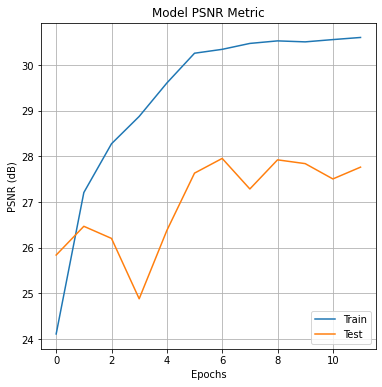

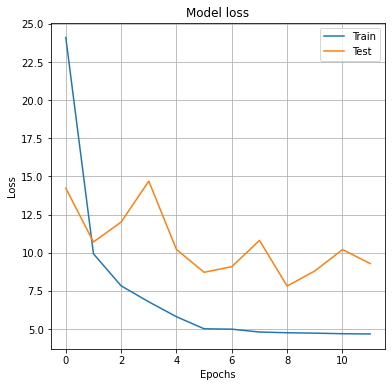

In [ ]:
# Plot training & validation accuracy values
plt.figure()
fig = plt.gcf()
fig.set_size_inches(6, 6)
plt.plot(history.history['PSNR'])
plt.plot(history.history['val_PSNR'])
plt.title('Model PSNR Metric')
plt.ylabel('PSNR (dB)')
plt.xlabel('Epochs')
plt.grid()
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

# Plot training & validation loss values
plt.figure()
fig = plt.gcf()
fig.set_size_inches(6, 6)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()
